<a href="https://colab.research.google.com/github/rafik-chemli/NRCan-Statcan-Furnace-CFD-Analysis/blob/main/NRCan_Statcan_Furnace_CFD_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:


# Define path of particle_data.csv
df_file_path = '/content/drive/MyDrive/Colab Notebooks/statcan/furnace/particle_data.csv'

# Load the data
data = pd.read_csv(df_file_path, skiprows=4)
data.head()

X [ m ]   Y [ m ]   Z [ m ]   Coal Particle.Boiling Point [ K ]  \
0     3.47     -2.00     -1.61                                87.3   
1     3.47     -2.01     -1.61                                87.3   
2     3.47     -2.01     -1.61                                87.3   
3     3.46     -2.01     -1.61                                87.3   
4     3.46     -2.01     -1.61                                87.3   

    Coal Particle.Injection   Coal Particle.Latent Heat [ J kg^-1 ]  \
0                       0.0                                161000.0   
1                       0.0                                161000.0   
2                       0.0                                161000.0   
3                       0.0                                161000.0   
4                       0.0                                161000.0   

    Coal Particle.Particle Binary Diffusivity  \
0                                     0.00003   
1                                     0.00003   
2                                     0.00003   
3                                     0.00003   
4                                     0.00003   

    Coal Particle.Particle Density [ kg m^-3 ]  \
0                                        200.0   
1                                        200.0   
2                                        200.0   
3                                        200.0   
4                                        200.0   

    Coal Particle.Particle Diameter [ m ]   Coal Particle.Particle ID  ...  \
0                                   0.002                         0.0  ...   
1                                   0.002                         0.0  ...   
2                                   0.002                         0.0  ...   
3                                   0.002                         0.0  ...   
4                                   0.002                         0.0  ...   

    Coal Particle.Particle Volatile Mass Fraction  \
0                                             0.6   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

    Coal Particle.Particle X Velocity [ m s^-1 ]  \
0                                         -0.641   
1                                         -3.100   
2                                         -4.490   
3                                         -6.450   
4                                         -7.400   

    Coal Particle.Particle Y Velocity [ m s^-1 ]  \
0                                         -0.707   
1                                         -3.280   
2                                         -4.810   
3                                         -6.890   
4                                         -7.920   

    Coal Particle.Particle Z Velocity [ m s^-1 ]  \
0                                          0.299   
1                                          1.470   
2                                          2.080   
3                                          2.920   
4                                          3.360   

    Coal Particle.Periodic Side   Coal Particle.Region  \
0                           0.0                   84.0   
1                           0.0                   84.0   
2                           0.0                   84.0   
3                           0.0                   84.0   
4                           0.0                   84.0   

    Coal Particle.Surface ID   Coal Particle.Tracking Scheme  \
0                       20.0                             3.0   
1                       20.0                             3.0   
2                       20.0                             3.0   
3                       20.0                             3.0   
4                       20.0                             3.0   

    Coal Particle.User Value 0  \
0                          0.0   
1                          0.0

In [ ]:
# Clean the column names by stripping leading/trailing spaces and replacing spaces with underscores
data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('.', '')

print(data.columns)

Index(['X_[_m_]', 'Y_[_m_]', 'Z_[_m_]', 'Coal_ParticleBoiling_Point_[_K_]',
       'Coal_ParticleInjection', 'Coal_ParticleLatent_Heat_[_J_kg^-1_]',
       'Coal_ParticleParticle_Binary_Diffusivity',
       'Coal_ParticleParticle_Density_[_kg_m^-3_]',
       'Coal_ParticleParticle_Diameter_[_m_]', 'Coal_ParticleParticle_ID',
       'Coal_ParticleParticle_Law_Index', 'Coal_ParticleParticle_Lewis_Number',
       'Coal_ParticleParticle_Liquid_Mass_Fraction',
       'Coal_ParticleParticle_Liquid_Volume_Fraction',
       'Coal_ParticleParticle_Mass_[_kg_]',
       'Coal_ParticleParticle_Nusselt_Number',
       'Coal_ParticleParticle_On_Wall_Flag',
       'Coal_ParticleParticle_Radial_Position_[_m_]',
       'Coal_ParticleParticle_Radial_Velocity_[_m_s^-1_]',
       'Coal_ParticleParticle_Reynolds_Number',
       'Coal_ParticleParticle_Specific_Heat',
       'Coal_ParticleParticle_Swirl_Velocity_[_m_s^-1_]',
       'Coal_ParticleParticle_Temperature_[_K_]',
       'Coal_ParticleParticle_Thet

<ipython-input-5-62ad2d62c66e>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('.', '')


In [ ]:

# Constants: Density and Surface Tension of the bottom liquid
rho_L = 3440
gamma = 0.568

def calculate_we_bo_lambda(row):
    # Extract necessary values from the row using the updated column names
    particle_velocity = [row['Coal_ParticleParticle_X_Velocity_[_m_s^-1_]'],
                         row['Coal_ParticleParticle_Y_Velocity_[_m_s^-1_]'],
                         row['Coal_ParticleParticle_Z_Velocity_[_m_s^-1_]']]
    particle_diameter = row['Coal_ParticleParticle_Diameter_[_m_]']
    particle_density = row['Coal_ParticleParticle_Density_[_kg_m^-3_]']

    # Weber and Bond number calculations
    We = rho_L * (particle_velocity[1] ** 2) * particle_diameter / gamma
    Bo = rho_L * 9.81 * (particle_diameter ** 2) / gamma
    lambda_squared = (particle_density / rho_L) ** 2

    return We, Bo, lambda_squared

def determine_fate(row):
    We, Bo, lambda_squared = calculate_we_bo_lambda(row)
    WeBo = We * np.sqrt(Bo ** 3)

    if WeBo >= 12 / lambda_squared:
        return 0  # Penetrating the surface
    elif 6 / lambda_squared <= WeBo < 12 / lambda_squared:
        return 1  # Bouncing
    else:
        return 2  # Oscillating/afloat

# Apply the function to each row to determine fate
data['fate'] = data.apply(determine_fate, axis=1)

# Now your DataFrame 'data' has a new column 'fate'
print(data[['fate']].head())


   fate
0     2
1     2
2     2
3     2
4     2


In [ ]:
print(data.columns)

Index(['X_[_m_]', 'Y_[_m_]', 'Z_[_m_]', 'Coal_ParticleBoiling_Point_[_K_]',
       'Coal_ParticleInjection', 'Coal_ParticleLatent_Heat_[_J_kg^-1_]',
       'Coal_ParticleParticle_Binary_Diffusivity',
       'Coal_ParticleParticle_Density_[_kg_m^-3_]',
       'Coal_ParticleParticle_Diameter_[_m_]', 'Coal_ParticleParticle_ID',
       'Coal_ParticleParticle_Law_Index', 'Coal_ParticleParticle_Lewis_Number',
       'Coal_ParticleParticle_Liquid_Mass_Fraction',
       'Coal_ParticleParticle_Liquid_Volume_Fraction',
       'Coal_ParticleParticle_Mass_[_kg_]',
       'Coal_ParticleParticle_Nusselt_Number',
       'Coal_ParticleParticle_On_Wall_Flag',
       'Coal_ParticleParticle_Radial_Position_[_m_]',
       'Coal_ParticleParticle_Radial_Velocity_[_m_s^-1_]',
       'Coal_ParticleParticle_Reynolds_Number',
       'Coal_ParticleParticle_Specific_Heat',
       'Coal_ParticleParticle_Swirl_Velocity_[_m_s^-1_]',
       'Coal_ParticleParticle_Temperature_[_K_]',
       'Coal_ParticleParticle_Thet

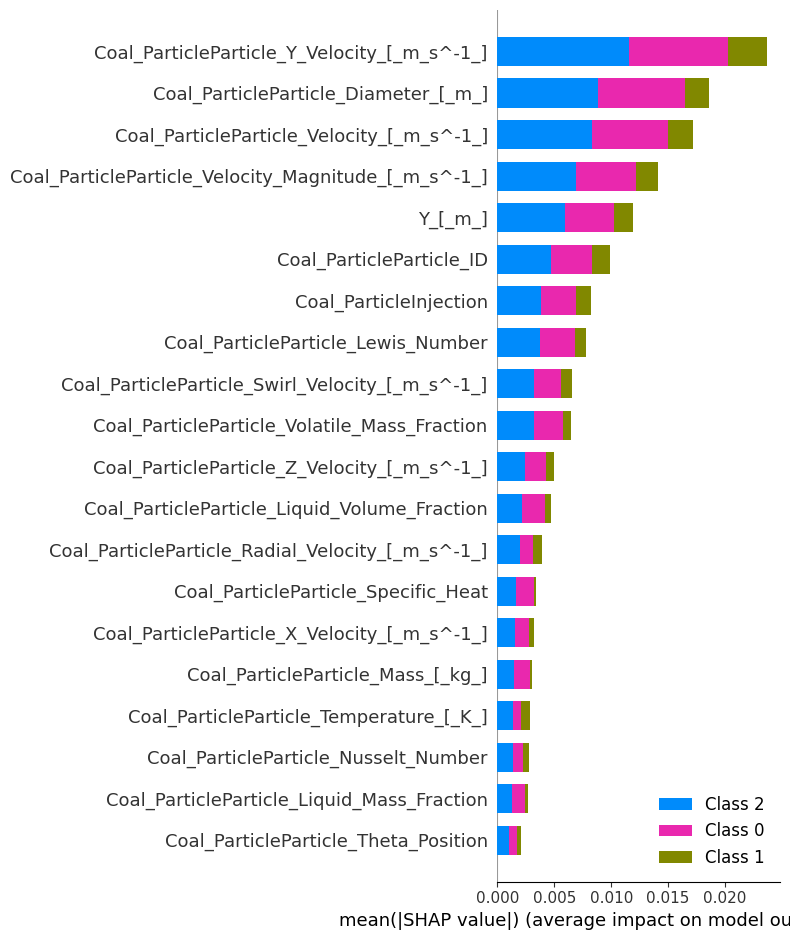

In [ ]:

shap_process = True
if shap_process == True:
  !pip install shap
  import shap
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import train_test_split

  # Assuming 'data' is your DataFrame
  X = data.drop('fate', axis=1)
  y = data['fate']

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train a model
  model = RandomForestClassifier(random_state=42)
  model.fit(X_train, y_train)

  # Create the SHAP Explainer
  explainer = shap.TreeExplainer(model)

  # Calculate SHAP values
  shap_values = explainer.shap_values(X_test)

  # Summarize the effects of all the features
  shap.summary_plot(shap_values, X_test)


In [ ]:
import plotly.express as px

# Convert 'fate' to a categorical type
data['fate'] = data['fate'].astype('float')

# Create a Parallel Coordinates plot including 'fate' in the dimensions
fig = px.parallel_coordinates(data,
                              # color='fate',
                              dimensions=[
                                  'Coal_ParticleParticle_Diameter_[_m_]',
                                  'Coal_ParticleParticle_Velocity_Magnitude_[_m_s^-1_]',
                                  'Coal_ParticleParticle_Density_[_kg_m^-3_]',
                                  'Coal_ParticleParticle_Temperature_[_K_]',
                                  'fate'
                              ],
                              # labels={'fate': 'Particle Fate'},
                              # color_continuous_scale=px.colors.diverging.Tealrose,
                              # color_continuous_midpoint=2
                              )

fig.show()
